In [2]:
%matplotlib inline

In [3]:
%load_ext line_profiler

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from arc import Rubidium85, ShirleyMethod

In [6]:
atom = Rubidium85()
t = [56, 2, 2.5]

mj = 0.5
q = 0

In [7]:
m = ShirleyMethod(atom)
m.defineBasis(
    *t,
    mj,
    basisStates=[
        [56, 2, 2.5, 0.5],
        [57, 1, 1.5, 0.5]
    ],
    progressOutput=True,
    debugOutput=False,
)
m.defineShirleyHamiltonian(fn=1)

Generating matrix...
100%
Energies and Couplings Generated


In [81]:
Efield = 5 # V/m
f0 = 12.0073e9 # Hz

efields = np.geomspace(1e-4, 1, 10) * Efield
freqs = np.linspace(-1e9, 1e9, 101) + f0

In [9]:
m.diagonalise(Efield, freqs, progressOutput=True)

Finding eigenvectors...


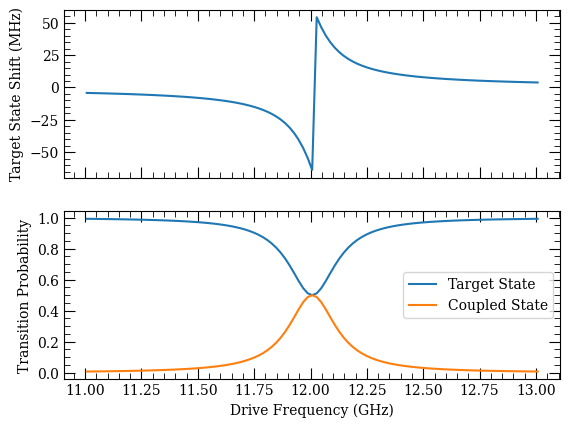

In [10]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

ax1.plot(freqs*1e-9, m.targetShifts*1e-6)

ax2.plot(freqs*1e-9, m.transProbs[:,0], label='Target State')
ax2.plot(freqs*1e-9, m.transProbs[:,1], label='Coupled State')
ax1.set_ylabel('Target State Shift (MHz)')
ax2.set_ylabel('Transition Probability')
ax2.set_xlabel('Drive Frequency (GHz)')
ax2.legend();

Diagonalize a single point

In [169]:
m.diagonalise(Efield/10, f0-1e7, progressOutput=True)

Finding eigenvectors...


In [170]:
dim0 = len(m.basisStates)
dim1 = 2*m.fn + 1
refInd = m.fn + dim0
tarInd = m.indexOfCoupledState + refInd
eigs = m.eigs.copy()
egvector = m.eigVectors.copy()

In [171]:
print(eigs)
print(eigs.shape)
print(egvector)
print(egvector.shape)

[-1.12537283e+12 -1.11337862e+12 -1.11336247e+12 -1.10138132e+12
 -1.10136516e+12 -1.08937095e+12]
(6,)
[[-0.00000000e+00+0.j  4.37375965e-01+0.j -8.99278747e-01+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  7.01227815e-08+0.j]
 [ 9.99999965e-01+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  -1.15859242e-04+0.j -2.38055220e-04+0.j  0.00000000e+00+0.j]
 [-2.64752048e-04+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
  -4.37375949e-01+0.j -8.99278716e-01+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j -8.99278716e-01+0.j -4.37375949e-01+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  2.64752048e-04+0.j]
 [ 0.00000000e+00+0.j  2.38055220e-04+0.j  1.15859242e-04+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  9.99999965e-01+0.j]
 [ 7.01227815e-08+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   8.99278747e-01+0.j -4.37375965e-01+0.j  0.00000000e+00+0.j]]
(6, 6)


In [172]:
m1 = (np.abs(np.conj(egvector) * egvector[tarInd])**2)
print(m1.shape)
m2 = m1.reshape((2 * m.fn + 1, dim0, (2 * m.fn + 1) * dim0))
print(m2.shape)
m3 = m2.sum(axis=(0,-1))
print(m3)
print(m3.sum())

(6, 6)
(3, 2, 6)
[0.30940592 0.69059408]
0.9999999999999992


In [39]:
tau = 1/f0
print(f'Drive period: {tau*1e12:.3f} fs')
ts = np.linspace(0, 2*tau, 100)

Drive period: 83.283 fs


In [40]:
u1 = np.exp(-1.0j*2*np.pi*eigs[None,:]*ts[:,None])
print(u1.shape)
u2 = np.conj(egvector)*egvector[tarInd]
print(u2.shape)
u3 = np.abs(np.einsum('lm,mk->lk',u1, u2))**2
print(u3.shape)
u4 = u3.reshape(u3.shape[:-1] + (dim1, dim0))
print(u4.shape)
u5 = u4.sum(axis=(-2))
print(u5.shape)

(100, 6)
(6, 6)
(100, 6)
(100, 3, 2)
(100, 2)


In [41]:
print(u4[51,...])

[[0.00000000e+00 2.15022557e-01]
 [3.31630751e-01 0.00000000e+00]
 [0.00000000e+00 7.01307695e-08]]


In [176]:
u1 = np.exp(-1.0j*2*np.pi*eigs[None,:]*ts[:,None])
print(u1.shape)
u3 = np.abs(np.einsum('lm,mk,m->lk',u1, np.conj(egvector), egvector[tarInd]))**2
print(u3.shape)
print(u4[51,...])
u4 = u3.reshape(u3.shape[:-1] + (dim1, dim0))
print(u4.shape)
u5 = u4.sum(axis=(-2))
print(u5.shape)

(100, 6)
(100, 6)
[[0.00000000e+00 2.15022557e-01]
 [3.31630751e-01 0.00000000e+00]
 [0.00000000e+00 7.01307695e-08]]
(100, 3, 2)
(100, 2)


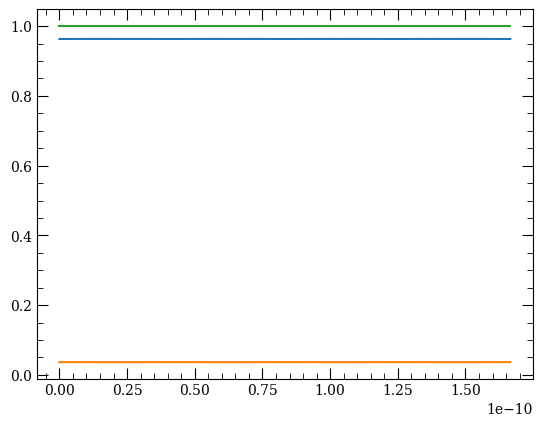

In [177]:
fig, ax = plt.subplots(1)

ax.plot(ts, u5)
ax.plot(ts, u5.sum(axis=-1))

Diagonalize the whole array

In [179]:
m.diagonalise(efields, freqs, progressOutput=True)

Finding eigenvectors...


In [156]:
tau = 1/f0
print(f'Drive period: {tau*1e12:.3f} fs')
ts = np.linspace(0, 2*tau, 100)

Drive period: 83.283 fs


In [157]:
dim0 = len(m.basisStates)
dim1 = 2*m.fn + 1
refInd = m.fn + dim0
tarInd = m.indexOfCoupledState + refInd

In [183]:
ut = np.exp(-1.0j*2*np.pi*np.einsum('...i,j->j...i', m.eigs, ts))
print(ut.shape)
print(m.eigVectors.shape)
print(m.eigVectors[...,tarInd,:].shape)

(100, 10, 101, 6)
(10, 101, 6, 6)
(10, 101, 6)


In [109]:
u2 = np.einsum('l...m,...mk,...k->l...k',
                    ut,
                    np.conj(m.eigVectors),
                    m.eigVectors[...,tarInd,:]
                   )
print(u2.shape)

(5, 10, 101, 6)


In [130]:
t2 = (np.conj(m.eigVectors[-1,51])*m.eigVectors[-1,51,tarInd,:])
print(t2)
t1 = np.einsum('...mk,...k->...mk', np.conj(m.eigVectors),m.eigVectors[...,tarInd,:])
print(t1[-1,51])

[[-4.97293750e-30+0.j -4.94005737e-01-0.j  4.94005718e-01+0.j
   2.39917780e-36+0.j  1.58169026e-36+0.j  1.84723850e-08+0.j]
 [-3.07530699e-14+0.j  1.29944940e-14+0.j  1.75439505e-14+0.j
   4.23355780e-20+0.j  2.94083438e-20+0.j  1.16967668e-19+0.j]
 [ 8.13177569e-17+0.j -5.72457093e-17-0.j -7.77563912e-17-0.j
   1.59745128e-17+0.j  1.11562005e-17+0.j  2.64209322e-17+0.j]
 [ 9.45757920e-28+0.j  4.22817815e-01+0.j  5.77175193e-01+0.j
   4.42127556e-34+0.j  2.94360375e-34+0.j  6.99182893e-06+0.j]
 [-1.94721145e-30+0.j -1.11457047e-03-0.j -1.52962696e-03-0.j
  -1.61076844e-31+0.j -1.12383335e-31-0.j  2.64419743e-03+0.j]
 [-2.14841199e-19+0.j  3.00524941e-19+0.j  4.13337867e-19+0.j
  -1.36726262e-17+0.j  1.30345195e-17+0.j  1.40605310e-19+0.j]]
[[-4.97293750e-30+0.j -4.94005737e-01+0.j  4.94005718e-01+0.j
   2.39917780e-36+0.j  1.58169026e-36+0.j  1.84723850e-08+0.j]
 [-3.07530699e-14+0.j  1.29944940e-14+0.j  1.75439505e-14+0.j
   4.23355780e-20+0.j  2.94083438e-20+0.j  1.16967668e-19+0.j]

In [148]:
t2 = (np.conj(m.eigVectors[-1,51])*m.eigVectors[-1,51,tarInd,:])[None,:,:]*ut[:,-1,51,:,None]
print(t2[0])
t1 = np.einsum('l...m,...mk,...m->l...k',ut, np.conj(m.eigVectors),m.eigVectors[...,tarInd,:])
#print(t1.shape)
print(t1[0,-1,51])

[[-4.97293750e-30+0.j -4.94005737e-01-0.j  4.94005718e-01+0.j
   2.39917780e-36+0.j  1.58169026e-36+0.j  1.84723850e-08+0.j]
 [-3.07530699e-14+0.j  1.29944940e-14+0.j  1.75439505e-14+0.j
   4.23355780e-20+0.j  2.94083438e-20+0.j  1.16967668e-19+0.j]
 [ 8.13177569e-17+0.j -5.72457093e-17-0.j -7.77563912e-17-0.j
   1.59745128e-17+0.j  1.11562005e-17+0.j  2.64209322e-17+0.j]
 [ 9.45757920e-28+0.j  4.22817815e-01+0.j  5.77175193e-01+0.j
   4.42127556e-34+0.j  2.94360375e-34+0.j  6.99182893e-06+0.j]
 [-1.94721145e-30+0.j -1.11457047e-03-0.j -1.52962696e-03-0.j
  -1.61076844e-31+0.j -1.12383335e-31-0.j  2.64419743e-03+0.j]
 [-2.14841199e-19+0.j  3.00524941e-19+0.j  4.13337867e-19+0.j
  -1.36726262e-17+0.j  1.30345195e-17+0.j  1.40605310e-19+0.j]]
[ 6.48233314e-01+0.j  3.62778100e-14+0.j -5.07505594e-15+0.j
 -5.76765014e-01+0.j  4.97127437e-01+0.j  7.63692332e-15+0.j]


In [144]:
t2.sum(axis=-1)[0]

array([-7.70737877e-17+0.j, -2.14436650e-16+0.j, -1.32698200e-19+0.j,
        1.00000000e+00+0.j,  1.73472348e-18+0.j,  1.52030640e-21+0.j])

In [115]:
us = u2[:,-1,51]
us2 = us.reshape(us.shape[:-1] + (dim1, dim0))
print(us2)
print(np.abs(us2))
print(np.abs(us2)**2)
print(np.sum(np.abs(us2)**2, axis=-2))

[[[-3.06719670e-14+0.00000000e+00j -7.23024925e-02+0.00000000e+00j]
  [ 1.06965128e+00+0.00000000e+00j  2.34422217e-18+0.00000000e+00j]
  [ 2.42201284e-17+0.00000000e+00j  2.65120773e-03+0.00000000e+00j]]

 [[ 2.03640778e-14-2.29363624e-14j -4.43614866e-02+5.72408660e-02j]
  [ 7.02587977e-01-8.06537533e-01j -1.40393661e-18+1.88183351e-18j]
  [-1.55500963e-17+1.85687091e-17j  1.68170701e-03-2.04957141e-03j]]

 [[ 3.63137731e-15+3.04564274e-14j  1.81306968e-02+7.04709711e-02j]
  [-1.46655311e-01-1.05950991e+00j -6.71120830e-19-2.26115121e-18j]
  [-4.25222079e-18-2.38429142e-17j -5.17726719e-04-2.60014953e-03j]]

 [[-2.51863244e-14-1.75055438e-14j  6.73045040e-02+2.91378467e-02j]
  [-8.95186410e-01-5.85324059e-01j  2.22964031e-18+8.22616098e-19j]
  [ 2.10087027e-17+1.20473858e-17j -2.33848928e-03-1.24907234e-03j]]

 [[ 2.98128209e-14-7.21182819e-15j  6.50337920e-02-3.55970062e-02j]
  [-1.02928100e+00+2.90508361e-01j -2.01601851e-18+1.30474393e-18j]
  [-2.27231445e-17+8.37129757e-18j -2.44

In [186]:
operand = (np.abs(np.einsum('...mk,l...m,...m->l...k',
                    np.conj(m.eigVectors),
                    ut,
                    m.eigVectors[...,tarInd,:]
                   ))**2).reshape(ut.shape[:-1] + (dim1, dim0)
                            ).sum(axis=-2)
print(operand.shape)

(100, 10, 101, 2)


Text(0.5, 0, 'Time ($\\tau$)')

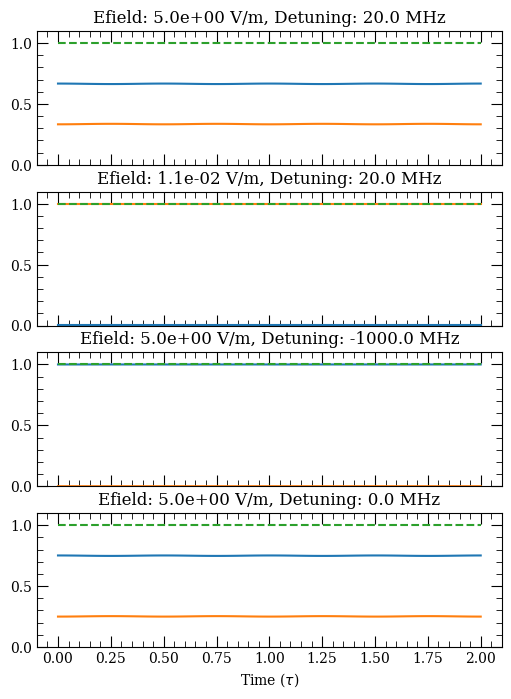

In [187]:
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4, sharex=True, figsize=(6,8),sharey=True)

ax1.set_ylim((0,1.1))
e = -1; f = 51;
ax1.set_title(f'Efield: {efields[e]:.1e} V/m, Detuning: {(freqs[f]-f0)*1e-6:.1f} MHz')
ax1.plot(ts/tau, operand[:,e,f,:])
ax1.plot(ts/tau, operand[:,e,f,:].sum(axis=-1), '--')

e = 3; f = 51;
ax2.set_title(f'Efield: {efields[e]:.1e} V/m, Detuning: {(freqs[f]-f0)*1e-6:.1f} MHz')
ax2.plot(ts/tau, operand[:,e,f,:])
ax2.plot(ts/tau, operand[:,e,f,:].sum(axis=-1), '--')

e = -1; f = 0;
ax3.set_title(f'Efield: {efields[e]:.1e} V/m, Detuning: {(freqs[f]-f0)*1e-6:.1f} MHz')
ax3.plot(ts/tau, operand[:,e,f,:])
ax3.plot(ts/tau, operand[:,e,f,:].sum(axis=-1), '--')

e = -1; f = 50;
ax4.set_title(f'Efield: {efields[e]:.1e} V/m, Detuning: {(freqs[f]-f0)*1e-6:.1f} MHz')
ax4.plot(ts/tau, operand[:,e,f,:])
ax4.plot(ts/tau, operand[:,e,f,:].sum(axis=-1), '--')
ax4.set_xlabel('Time ($\\tau$)')